In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../lib")

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import temporal_encoder_common
from temporal_encoder_common import Filters
import nonneg_common
import lif_utils
import nengo
import dlop_ldn_function_bases as bases

np.set_printoptions(precision=4, suppress=True)

In [4]:
def LP(*args):
    return nengo.LinearFilter(*Filters.lowpass_laplace(*args), analog=True)

In [7]:
n_neurons = 100
n_temporal_dimensions = 2

gains, biases, TEs = nonneg_common.mk_ensemble(n_neurons, d=n_temporal_dimensions, max_rates=(200.0, 200.0,))
G = lif_utils.lif_rate

A = np.array((
    (0.0, 2.0 * np.pi * 2.0),
    (-2.0 * np.pi * 2.0, 0.0),
))
B = np.array((1.0, 0.0,)).T

T, dt = 3.0, 1e-3
ts = np.arange(0, T, dt)
Ms = temporal_encoder_common.cached_lti_impulse_response(A, B, ts)

flts_in = [(tau,) for tau in np.geomspace(100e-3, 200e-3, 5)]
flts_rec = [(tau,) for tau in np.geomspace(100e-3, 200e-3, 5)]

In [8]:
np.random.seed(58381)
Y_nonlin, XS = None, None
W_in, W_rec, Y_nonlin, XS, AS = temporal_encoder_common.solve_for_recurrent_population_weights_nonlin(
    G, gains, biases, None, None, TEs,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    Y_nonlin=Y_nonlin,
    XS = XS,
    N_smpls=101,
    xs_sigma=3.0,
    T=T,
    dt=dt,
    biased=True,)

100%|██████████| 101/101 [00:01<00:00, 85.60it/s]


In [9]:
# Compute the adaptation current for each neuron
h = np.exp(-ts / 0.05)
h /= np.sum(h)
J_adap2 = np.array([[0.01 * np.convolve(AS[i, j], h, 'valid') for j in range(AS.shape[1])] for i in range(AS.shape[0])])

In [11]:
Y_nonlin = J_adap2[..., -1] / gains[None, :]

In [13]:
np.random.seed(58381)
W_in, W_rec, Y_nonlin, XS, AS = temporal_encoder_common.solve_for_recurrent_population_weights_nonlin(
    G, gains, biases, None, None, TEs,
    [Filters.lowpass(*flt_in) for flt_in in flts_in],
    [Filters.lowpass(*flt_rec) for flt_rec in flts_rec],
    Ms=Ms,
    Y_nonlin=Y_nonlin,
    XS = XS,
    N_smpls=101,
    xs_sigma=3.0,
    T=T,
    dt=dt,
    biased=True,)

100%|██████████| 101/101 [00:01<00:00, 85.52it/s]


In [14]:
def execute_network_ref(
                    XS,
                    AS,
                    TEs,
                    W_in,
                    W_rec,
                    gains,
                    biases,
                    flts_in,
                    flts_rec,
                    dt=1e-3):
    N = len(XS)
    T = N * dt
    n_neurons = len(gains)
    n_dims = TEs.shape[1]

    with nengo.Network() as model:
        nd_ref = nengo.Node(lambda t: AS[:, int(t / dt) % N])
        ens_ref = nengo.Ensemble(n_neurons=n_neurons,
                                 dimensions=1,
                                 bias=np.zeros(n_neurons),
                                 gain=np.ones(n_neurons),
                                 neuron_type=nengo.SpikingRectifiedLinear())

        nengo.Connection(nd_ref, ens_ref.neurons, transform=np.eye(n_neurons))

        nd_in = nengo.Node(lambda t: XS[int(t / dt) % N])

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=n_dims,
                               bias=biases,
                               gain=gains,
                               encoders=TEs,
                               neuron_type=nengo.AdaptiveLIF(tau_n=0.05))

        for i, flt_in in enumerate(flts_in):
            nengo.Connection(nd_in,
                             ens_x.neurons,
                             transform=W_in[:, i:(i+1)],
                             synapse=LP(*flt_in))

        for i, flt_rec in enumerate(flts_rec):
            nengo.Connection(ens_ref.neurons,
                             ens_x.neurons,
                             transform=W_rec[:, :, i],
                             synapse=LP(*flt_rec))

        p_ref_in = nengo.Probe(nd_ref, synapse=100e-3)
        p_ref_as = nengo.Probe(ens_ref.neurons, synapse=None)
        p_out_as = nengo.Probe(ens_x.neurons, synapse=None)
        p_out_ns = nengo.Probe(ens_x.neurons, 'adaptation', synapse=None)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    return sim.trange(), sim.data[p_ref_in], sim.data[p_ref_as], sim.data[p_out_as], sim.data[p_out_ns]

np.random.seed(498184)
ts, ref_in, ref_as, out_as, out_ns = execute_network_ref(XS[2], AS[12], TEs, W_in, W_rec, gains, biases, flts_in, flts_rec)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

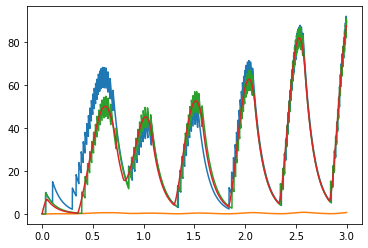

In [17]:
fig, ax = plt.subplots()
ax.plot(ts, nengo.Lowpass(100e-3).filt(out_as[:, 15]));
ax.plot(ts, nengo.Lowpass(100e-3).filt(out_ns[:, 15]));
ax.plot(ts, nengo.Lowpass(100e-3).filt(ref_as[:, 15]));
ax.plot(ts, nengo.Lowpass(100e-3).filt(AS[12, 15]));

In [76]:
np.mean(AS[2, 4, -200:])

0.0

In [77]:
def compute_mean_rate(ts, As):
    res = np.zeros(As.shape[1])
    for i in range(As.shape[1]):
        TS = ts[As[:, i] != 0.0]
        if len(TS) <= 1:
            res[i] = np.inf
        else:
            res[i] = np.mean(TS[1:] - TS[:-1])
    return 1.0 / res

In [78]:
compute_mean_rate(ts[-200:], out_as[-200:]), np.mean(AS[2, :, -200:], axis=-1)

(array([  0.    , 106.599 ,   0.    ,  74.0741,   0.    ,   0.    ,
         96.9388,   0.    ,   0.    , 150.2591,  75.6757,  48.6486,
        112.3596,   0.    , 134.715 ,  77.6699,   0.    , 125.    ,
        104.712 ,  78.125 ,   0.    , 145.0777,   0.    ,   0.    ,
         32.4324,   0.    , 118.2796,  74.8299, 123.6559,  99.4475,
          0.    ,   0.    ,   0.    ,   0.    ,   0.    , 102.9412,
        108.8083,   0.    , 102.0408,  17.2414,  22.7273,  72.6257,
        139.0374,  64.5161,  82.5688, 109.9476, 108.2474,  76.5027,
         74.0741,  75.    ,  26.455 ,   0.    ,   0.    , 149.4845,
          0.    ,  99.4764,  50.    ,   0.    ,   0.    ,   0.    ,
         88.6076, 116.0221, 150.2591,   0.    , 106.9519,   0.    ,
         84.7458, 127.6596,  91.3978,   0.    ,  97.2973,  97.2222,
         97.4359,  81.6327,  80.    ,   0.    ,  90.2256, 124.3243,
        125.6545,   0.    ,   0.    ,   0.    ,   0.    , 132.9787,
          0.    ,   0.    , 128.3422,  96.4467, 

In [79]:
def execute_network(xs,
                    TEs,
                    W_in,
                    W_rec,
                    gains,
                    biases,
                    flts_in,
                    flts_rec,
                    T=10.0,
                    dt=1e-3):
    if xs is None:
        N = int(T / dt + 1e-9)
    else:
        N = len(xs)
        T = N * dt
    n_neurons = len(gains)
    n_dims = TEs.shape[1]

    with nengo.Network() as model:
        if xs is None:
            nd_in = nengo.Node(lambda t: 30.0 * (t >= 0.1) * (t < 0.15))
        else:
            nd_in = nengo.Node(lambda t: xs[int(t / dt) % N])

        ens_x = nengo.Ensemble(n_neurons=n_neurons,
                               dimensions=n_dims,
                               bias=biases,
                               gain=gains,
                               encoders=TEs,
                               neuron_type=nengo.AdaptiveLIF(tau_n=0.05))

        for i, flt_in in enumerate(flts_in):
            nengo.Connection(nd_in,
                             ens_x.neurons,
                             transform=W_in[:, i:(i+1)],
                             synapse=LP(*flt_in))

        for i, flt_rec in enumerate(flts_rec):
            nengo.Connection(ens_x.neurons,
                             ens_x.neurons,
                             transform=W_rec[:, :, i],
                             synapse=LP(*flt_rec))

        p_in = nengo.Probe(nd_in, synapse=None)
        p_out = nengo.Probe(ens_x.neurons, synapse=None)
        p_out_dec = nengo.Probe(ens_x, synapse=100e-3)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T)

    return sim.trange(), sim.data[p_in], sim.data[p_out], sim.data[p_out_dec]

ts, us, As, xs = execute_network(None, TEs, W_in, W_rec, gains, biases, flts_in, flts_rec)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

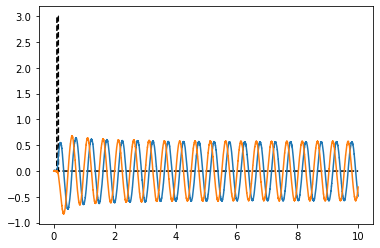

In [80]:
fig, ax = plt.subplots()
ax.plot(ts, 0.1 * us, 'k--')
ax.plot(ts, xs)

In [81]:
def fit_exp(ts, ys):
    from scipy.optimize import curve_fit
    def f(t, a, b):
        return a * np.exp(-t * b)
    return curve_fit(f, ts, ys, (1.0, 1.0), bounds=((0.0, 0.0), (np.inf, np.inf)))[0]

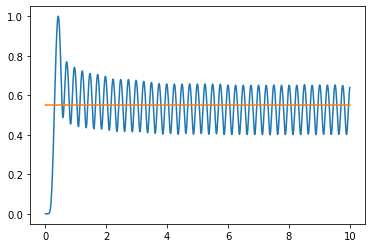

In [82]:
x1 = np.convolve(xs[:, 0], Ms[:200, 0], 'full')[:len(ts)]
x2 = np.convolve(xs[:, 0], Ms[:200, 1], 'full')[:len(ts)]
y1 = np.convolve(xs[:, 1], Ms[:200, 0], 'full')[:len(ts)]
y2 = np.convolve(xs[:, 1], Ms[:200, 1], 'full')[:len(ts)]
v = np.hypot(y1, y2) + np.hypot(y1, y2)
v /= np.max(v)

a, b = fit_exp(ts[:2000], v[:2000])

fig, ax = plt.subplots()
ax.plot(ts, v)
ax.plot(ts, a * np.exp(-ts * b))


In [83]:
a, b

(0.5509213803554108, 6.003121451995647e-14)

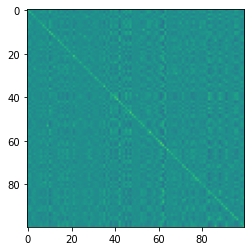

In [91]:
fig, ax = plt.subplots()
ax.imshow(W_rec[:, :, 1], vmin=-1e-3, vmax=1e-3)